### idea 
user input his(personality test answers)and the system recommeds his matching Cats 


### metodology 
since our users don't have any prior preferences towards Cats(user cold start problem) we have to start with this:

1. Finding **nearset user**: the system takes user input (personality test answers) then finds the nearsest user (the most similar one) from our DataSet
    - for better pridections : we filterd out users with staisfacton level blow 0.8 

2. we get the nearest user - **Connceted Cat** (from the DataSet)

3. based on the **Connceted Cat** the system recommends the nearset cat from an external data set "Cat_dataset_online"


some notes: 

- there isn't any active learning,the system just recommends based on the Dataset (aka. the scale where every user get his recommended cat)  
- due to the DataSet setup, each user is exposed to one and only one Cat (Aka. each user rates one Cat). so we are forced to use "**user_based** collaborative filtering", in Addition satisfaction here is based on live -interaction between the Adopter and the cat for some time, so the satisfaction is a reliable scale 




###  for relasing this we need 

- **important** write a reveiw on the results and specify why we used coverage as main evaluation 
- **important** explain what is version2 in more details and do coverage test 
- **good to try** for example jaccard distance as an alternative methoud 




##### done 
-  encapsulationg the version 2 into a proper function 
-  Cats random names feature 
- **impotant** try another algorism  (cosine simlarity done .... may evalute it according to coverage (done)

In [151]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

# pip install names
import names


pd.set_option('display.max_columns', 1000)

## Dataset preparation 

In [152]:
df = pd.read_excel('https://github.com/TechLabs-Berlin/wt21-pet-match/blob/main/ds_documentation/data_set/data_cleaned/all_cleaned_num.xlsx?raw=true')
#df.describe()

In [153]:
df = df.set_index('id').drop(columns = 'breed')
## we only had ~640 who spcifiy the breed name out of 3331,so we decided to drop this feature at this version of the recommender 

In [154]:
df.head()

,cat_age,cat_gender,needs_outdoor,medical_conditions,behavioural_problems,cat_weight,likes_to_explore,playful,vocal,picked_up,timid,aggressive,adapts_quickly,prefers_alone,likes_stroke,tolerant_handled,friendly,fearful,adopter_gender,adopter_age,other_cats,outdoor_access,worries,easily_nervous,remains_calm,talkative,outgoing,reserved,new_ideas,values_artistic,active_imagination,rude,forgiving,considerate,thorough job,lazy,efficient,satisf_level
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6,1,2,2,1,3,4,4,3,2,3,1,3,2,4,3,4,5,2,2,2,2,5,4,4,4,4,4,2,5,3,1,4,5,4,4,4,1.00
1,2,2,2,1,1,3,4,4,1,4,3,3,2,3,4,3,5,2,2,2,0,2,5,5,5,4,3,5,4,3,4,3,5,5,5,1,5,1.00
2,5,1,1,1,1,4,5,3,4,2,2,3,4,3,3,2,3,3,2,1,0,1,5,0,0,4,0,2,3,0,4,0,4,0,5,0,0,0.85
3,4,2,2,1,1,4,3,4,3,5,4,2,2,2,5,4,4,4,2,1,1,2,5,5,2,4,3,4,4,5,5,4,5,4,3,4,3,1.00
4,3,2,2,1,1,5,4,3,5,2,3,1,4,3,4,3,4,3,2,2,3,2,4,4,4,2,3,4,3,3,3,3,4,4,4,4,4,1.00


### Random Cat-Names feature

- to for the easy identifaction of Cats 

In [155]:
## based on the index no. it checks the Cat's gender then it assign a name for it  
def Random_names(i):
    
    while i < len(df):
        if df["cat_gender"][df.index[i]] == 1:
            return str(names.get_first_name(gender='male'))
        else:
            return str(names.get_first_name(gender='female'))
        

In [156]:
temp_names = []
for n in df.index:
    random_name=Random_names(n)
    temp_names.append(random_name)
    
#print(temp_names)
df["cat_name"] = temp_names 

In [157]:
df

,cat_age,cat_gender,needs_outdoor,medical_conditions,behavioural_problems,cat_weight,likes_to_explore,playful,vocal,picked_up,timid,aggressive,adapts_quickly,prefers_alone,likes_stroke,tolerant_handled,friendly,fearful,adopter_gender,adopter_age,other_cats,outdoor_access,worries,easily_nervous,remains_calm,talkative,outgoing,reserved,new_ideas,values_artistic,active_imagination,rude,forgiving,considerate,thorough job,lazy,efficient,satisf_level,cat_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6,1,2,2,1,3,4,4,3,2,3,1,3,2,4,3,4,5,2,2,2,2,5,4,4,4,4,4,2,5,3,1,4,5,4,4,4,1.00,Robert
1,2,2,2,1,1,3,4,4,1,4,3,3,2,3,4,3,5,2,2,2,0,2,5,5,5,4,3,5,4,3,4,3,5,5,5,1,5,1.00,Karen
2,5,1,1,1,1,4,5,3,4,2,2,3,4,3,3,2,3,3,2,1,0,1,5,0,0,4,0,2,3,0,4,0,4,0,5,0,0,0.85,Johnny
3,4,2,2,1,1,4,3,4,3,5,4,2,2,2,5,4,4,4,2,1,1,2,5,5,2,4,3,4,4,5,5,4,5,4,3,4,3,1.00,Kathy
4,3,2,2,1,1,5,4,3,5,2,3,1,4,3,4,3,4,3,2,2,3,2,4,4,4,2,3,4,3,3,3,3,4,4,4,4,4,1.00,Denise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,12,2,1,1,1,3,5,5,3,4,4,1,4,2,5,4,5,2,2,5,2,1,2,1,4,4,4,2,3,4,3,1,5,5,4,1,4,1.00,Claire
3327,7,1,2,1,1,3,5,4,3,4,3,1,4,1,5,5,4,2,2,4,0,2,2,1,4,3,4,4,5,5,5,2,5,5,4,4,5,1.00,Jacob
3328,4,1,1,1,1,3,5,5,5,5,1,1,5,2,5,5,5,1,2,1,3,1,5,5,3,3,2,4,5,5,5,4,5,5,3,5,4,1.00,Alex


### filtering out the unstisfied users 

- the recommender needs the users and Adopters to be high satisfied, we choose to remove subjects with satisfaction less than 0.8 

<AxesSubplot:title={'center':'Satisfaction Distribution'}>

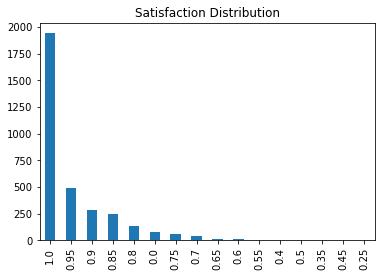

In [158]:
df['satisf_level'].value_counts().plot(kind='bar',title='Satisfaction Distribution' ,label= '.')

- nearly 58% are fully staisfied (satisfaction = 1), while (~10%) are blew 0.8 satisfaction.

In [159]:
#df['satisf_level'].value_counts(normalize = True)

### used Dataset (offline_Dataset)

In [160]:
df_happy = df.loc[df["satisf_level"] > 0.8].drop(columns=["satisf_level"]).reset_index(drop=True)

## Recommender idea

to enable the matching with new Cats that the Adopter have never seen the Rocmmender we do the following steps:
to do this we will need two Datasets:
 
1. the **original Dataset (offline Dataset)**: it contains the Adopter and cat Data together, this is the Recommender refrence
2. make a new **catDataset (cats online dataset)** to simulte the case of the website's cat database, for testing puposes it was made by producing a subset of the original Data (40% of the original data ~953cat)

steps 
1. the user input his data (using the questionare) .. this is applied using the API 
2. the rcommender apply the **1st cycle** of matching to get the **best_matching user**, based on a utility matrix table made from Adopter's features only 
3. the recommender extract the best user's **connected cat** data from the offline Dataset (1st choice)
4. the recommnder apply the **2nd cycle** of matching to get the **best_matching Cats** from the **cats online dataset**, based on a utility matrix table made from the cat features only 
5. the reommender sorts the results and gets the best 10 

### Cat online Dataset
- the online Dataset (Cat online) is a random sample of the original Dataset, we kept original IDs before doing ".sample" and coded it with "C" symbol (for debugging purposes), this will help to check the path of the data later. 

In [161]:
df_cats = df_happy.loc[:, "cat_age":"fearful"] 
df_cats_online=df_cats.sample(frac=0.4, replace=True, random_state=100).drop_duplicates()

# to cheak for duplictes using .sample
#print(len(df_cats["ID-cat"].unique()))
#print(len(df_cats_online["ID-cat"].unique()))
#len(df_cats_online["ID-cat"])

In [162]:
df_cats_online["ID-original"] =  "C-" + df_cats_online.index.astype(str)
df_cats_online = df_cats_online.set_index("ID-original")
df_cats_online

,cat_age,cat_gender,needs_outdoor,medical_conditions,behavioural_problems,cat_weight,likes_to_explore,playful,vocal,picked_up,timid,aggressive,adapts_quickly,prefers_alone,likes_stroke,tolerant_handled,friendly,fearful
ID-original,,,,,,,,,,,,,,,,,,
C-1544,1,1,1,2,1,3,5,5,3,5,1,1,5,1,5,5,5,1
C-2840,10,1,2,2,1,3,3,4,5,4,1,1,5,3,5,5,5,1
C-1859,4,1,2,1,1,3,5,5,1,4,4,1,3,2,5,5,4,4
C-79,5,1,2,1,1,3,5,5,5,4,3,1,3,1,3,3,5,1
C-1930,7,2,2,1,1,3,5,4,3,4,3,1,3,2,4,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C-1186,9,1,1,1,1,3,4,3,3,4,3,1,2,1,4,4,4,3
C-1245,1,1,1,1,2,3,5,4,3,5,2,1,4,3,3,5,4,1
C-865,15,1,2,1,2,3,5,5,5,5,1,1,4,1,5,5,5,1


### Finding nearest user (utility matrix table)

In [163]:
# setting up a subset for the users_only features 
df_adopters = df_happy.loc[:, "adopter_gender":"efficient"]
df_adopters

,adopter_gender,adopter_age,other_cats,outdoor_access,worries,easily_nervous,remains_calm,talkative,outgoing,reserved,new_ideas,values_artistic,active_imagination,rude,forgiving,considerate,thorough job,lazy,efficient
0,2,2,2,2,5,4,4,4,4,4,2,5,3,1,4,5,4,4,4
1,2,2,0,2,5,5,5,4,3,5,4,3,4,3,5,5,5,1,5
2,2,1,0,1,5,0,0,4,0,2,3,0,4,0,4,0,5,0,0
3,2,1,1,2,5,5,2,4,3,4,4,5,5,4,5,4,3,4,3
4,2,2,3,2,4,4,4,2,3,4,3,3,3,3,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,2,5,2,1,2,1,4,4,4,2,3,4,3,1,5,5,4,1,4
2963,2,4,0,2,2,1,4,3,4,4,5,5,5,2,5,5,4,4,5
2964,2,1,3,1,5,5,3,3,2,4,5,5,5,4,5,5,3,5,4
2965,2,3,1,1,4,4,4,1,5,2,3,5,4,4,1,5,5,2,5


In [164]:
# create utility matrix table to study the user and book relation
df_pivot=df_adopters.transpose()
df_pivot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,2689,2690,2691,2692,2693,2694,2695,2696,2697,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2713,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,

In [165]:
##to cheak no. of people who didnt fill at least half of the questionnare , only 75 persons so it is negegable 
df_pivot[df_pivot==0].apply(lambda x: x.count()>5).value_counts()

False    2892
True       75
dtype: int64

In [166]:
x=df_pivot.values.T  
#x.shape

####  engines used in Recommender 

##### Correlation Matrix 

In [167]:
corr_mat = np.corrcoef(x)
###another methoud using Dataframe 
#df_matrix= df_pivot.corr(method='pearson')
#df_matrix

##### cosine similarity 

In [168]:
## another engine consine simlatiy 
cos_sim_mat = cosine_similarity(x)

### 1st cycle : get nearest user's connceted cats 

this approch is not enough, as we recommend cats from our offline Data set, it is better to get the nearest cats from separte Dataset (apply the 2nd cycle ) 

- for testing purposes only, we applied 1 cycle correlation definition here

#### recommender (1 cycle)_using correlation matrix (for testing only) 

In [169]:
### to be deleted ####

def recommend_one_cycle(df_pivot, corr_mat):
    name=int (input("Enter the Adopter name you want to match: ")) ## reomve the int, case your input is string 
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            corr_Adopter = corr_mat[Adopter_index]
            tuples = list(zip(Adopter_names,corr_Adopter,Cat_names))
            tuples_df = pd.DataFrame(data =tuples, columns= ["ID_matching","correlation","cat_name"])
            print("the nearest 10 cats to ",Adopter_index ," are")
            print(tuples_df.sort_values(by = "correlation", ascending = False).iloc[1:11])
        
    except:
        print("Enter the Adopter Name Again")
        recommend_cat(df_pivot,corr_mat)    

#### recommender (1 cycle)_using cosine similarity (for testing only) 

In [170]:
def bestuser_one_cycle_cosineSim(cos_sim_mat):
    name=int (input("Enter the Adopter name you want to match: "))
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            cos_Adopter = cos_sim_mat[Adopter_index] 
            tuples2 = list(zip(Adopter_names,cos_Adopter,Cat_names))
            tuples_df2 = pd.DataFrame(data =tuples2, columns= ["ID_matching","correlation","cat_name"])
            print("the nearest 10 cats to ",Adopter_index ," are")
            print(tuples_df2.sort_values(by = "correlation", ascending = False).iloc[1:11])
        
    except:
        print("Enter the Adopter Name Again")

##### quick glance at the results

In [171]:
recommend_one_cycle(df_pivot, corr_mat)

Enter the Adopter name you want to match: 20
the nearest 10 cats to  20  are
      ID_matching  correlation cat_name
513           513     0.970695      Eva
1444         1444     0.958436   Dottie
1646         1646     0.942318   Cedric
2762         2762     0.926701     Phil
798           798     0.923953   Tyrone
438           438     0.920922    Carol
48             48     0.915050     Jena
170           170     0.913472  Ophelia
1002         1002     0.912423     Lisa
997           997     0.909107     Anne


In [172]:
bestuser_one_cycle_cosineSim(cos_sim_mat)

Enter the Adopter name you want to match: 20
the nearest 10 cats to  20  are
      ID_matching  correlation   cat_name
513           513     0.996101        Eva
1444         1444     0.994265     Dottie
1646         1646     0.992683     Cedric
2762         2762     0.990658       Phil
438           438     0.990202      Carol
798           798     0.990156     Tyrone
48             48     0.989469       Jena
2019         2019     0.988767    Rosalba
418           418     0.988767  Guadalupe
1673         1673     0.988710     Esther


- the recommender results are identical in the 1st four choices then it vary after that, and since we are only picking the best choice so the variation in this cycle may not be very important  

### 2nd cycle:  finding  the best matching Cat from an online dataset

- matching to get the **best_matching Cats** from the **cats online dataset**, based on a utility matrix table made from the cat features only   

In [173]:
df_cats_online
cat_Ids = df_cats_online.index

### input Adopter Data then Extract the best connected Cat  (For degugging )

In [174]:
##adopter things 
Adopter_names = df_pivot.columns
Adopter_list = list(Adopter_names)
Adopter_index = Adopter_list.index(20) ### Enter adopter ID here ### 
Cat_names = df_happy["cat_name"].tolist()

#applying the 1st cycle logic 
corr_Adopter = corr_mat[Adopter_index]


#best Adopter
best_adopter = list(zip(Adopter_names,corr_Adopter))
df_adopterDset = pd.DataFrame(data =best_adopter, columns= ["ID_Adopter","correlation_Adopter"])
print("the nearest adopter to ",Adopter_index ," is")
print(df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2])

# extracting best cat data from the offline Dataset
best_cat_index = df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2].index

best_cat =df_happy.loc[best_cat_index[0], "cat_age":"fearful"] ## extracting the conncected cat part 
#best_cat 


the nearest adopter to  20  is
     ID_Adopter  correlation_Adopter
513         513             0.970695


- from the original dataset: the neaerst Adopter to pick is "513"

####  Finding nearest connected cat ( cat -utility matrix table)

In [175]:
#adding our imaginary best cat to the online cat_dataset

df_cats_online_new =df_cats_online.append(best_cat , sort=False) ## in case index dont match 
df_pivot_cat=df_cats_online_new.transpose()
df_pivot_cat

##to cheak no. of samples which didnt fill at least half of the questionnare 
#df_pivot_cat[df_pivot==0].apply(lambda x: x.count()>5).value_counts()

ID-original,C-1544,C-2840,C-1859,C-79,C-1930,C-350,C-1972,C-1890,C-53,C-1602,C-1550,C-802,C-1009,C-2800,C-280,C-1679,C-1899,C-1340,C-2960,C-1531,C-1673,C-2134,C-2434,C-1691,C-1900,C-1924,C-2463,C-897,C-2805,C-1747,C-612,C-1028,C-2651,C-2883,C-135,C-2097,C-2365,C-782,C-763,C-2,C-889,C-617,C-2526,C-1427,C-2111,C-283,C-1393,C-806,C-2220,C-274,C-2240,C-437,C-1738,C-273,C-1608,C-1549,C-618,C-17,C-2116,C-488,C-2523,C-2003,C-2741,C-2894,C-13,C-1209,C-1484,C-2410,C-131,C-2630,C-1667,C-1236,C-394,C-1239,C-495,C-643,C-2921,C-1200,C-1835,C-2084,C-1797,C-839,C-2086,C-1118,C-2786,C-1194,C-2900,C-2143,C-1650,C-1100,C-2362,C-2150,C-938,C-2454,C-2810,C-1719,C-226,C-915,C-1845,C-2244,C-446,C-818,C-1476,C-2467,C-407,C-765,C-1813,C-409,C-262,C-1701,C-1894,C-1652,C-1210,C-1758,C-1843,C-2334,C-2626,C-243,C-439,C-2321,C-813,C-1509,C-2137,C-429,C-803,C-1040,C-1548,C-2669,C-1091,C-2268,C-788,C-2186,C-2824,C-473,C-2760,C-1438,C-1932,C-1682,C-1373,C-2935,C-1628,C-556,C-1081,C-2431,C-768,C-1609,C-1768,C-694,C-1858,C-1413,C-1459,C-346,C-2082,C-451,C-862,C-1998,C-2742,C-1101,C-212,C-2433,C-1038,C-1907,C-148,C-2216,C-2490,C-796,C-2002,C-2770,C-514,C-2623,C-2929,C-145,C-1274,C-477,C-736,C-2122,C-1822,C-668,C-1106,C-998,C-1425,C-653,C-2641,C-2933,C-2841,C-655,C-364,C-2170,C-2059,C-2661,C-1908,C-1814,C-2871,C-313,C-87,C-2739,C-1968,C-754,C-2045,C-506,C-1681,C-705,C-172,C-144,C-1206,C-2231,C-83,C-502,C-1578,C-1981,C-2808,C-2806,C-1829,C-1648,C-2161,C-465,C-2576,C-1094,C-994,C-1760,C-2953,C-2927,C-674,C-870,C-1163,C-1821,C-1885,C-2724,C-597,C-2652,C-2675,C-2372,C-119,C-829,C-2141,C-1522,C-804,C-2602,C-2829,C-304,C-2514,C-2592,C-2342,C-1320,C-2545,C-1422,C-38,C-628,C-214,C-1189,C-2176,C-872,C-2747,C-809,C-2189,C-2040,C-2135,C-2113,C-324,C-2230,C-2688,C-2391,C-1619,C-2826,C-2793,C-833,C-1154,C-2263,C-2087,C-758,C-1316,C-1315,C-1635,C-659,C-2180,C-1751,C-2634,C-909,C-2721,C-1368,C-2711,C-234,C-1595,C-2552,C-1032,C-1613,C-303,C-2807,C-1817,C-1392,C-1951,C-550,C-2512,C-215,C-468,C-357,C-2108,C-783,C-2451,C-660,C-1155,C-2405,C-11,C-1328,C-1926,C-2705,C-1385,C-2764,C-186,C-456,C-1787,C-2483,C-1659,C-158,C-1646,C-1234,C-1307,C-2374,C-2036,C-1837,C-1319,C-1458,C-942,C-2364,C-1488,C-2128,C-633,C-34,C-1233,C-470,C-1839,C-2943,C-2947,C-375,C-2777,C-1285,C-2754,C-1979,C-649,C-397,C-1347,C-2174,C-2895,C-2294,C-340,C-1871,C-1933,C-2379,C-1585,C-1765,C-2260,C-2854,C-1445,C-1624,C-1939,C-21,C-2048,C-1865,C-2797,C-292,C-1203,C-1057,C-2400,C-854,C-2809,C-410,C-507,C-2646,C-1502,C-2083,C-2835,C-2290,C-1716,C-1961,C-1838,C-690,C-1256,C-77,C-1868,C-2915,C-2027,C-1597,C-1852,C-2706,C-35,C-2103,C-2118,C-1433,C-2783,C-1643,C-698,C-2380,C-700,C-2065,C-1569,C-194,C-990,C-18,C-2534,C-748,C-997,C-1543,C-485,C-1008,C-1214,C-129,C-1791,C-333,C-926,C-2396,C-1680,C-2513,C-1376,C-20,C-1362,C-1510,C-1379,C-2903,C-2299,C-1496,C-2517,C-513,C-491,C-1018,C-478,C-2012,C-603,C-1430,C-1357,C-1712,C-879,C-187,C-1929,C-1477,C-1074,C-62,C-1991,C-817,C-14,C-2049,C-120,C-369,C-2546,C-2489,C-505,C-794,C-594,C-2448,C-563,C-1519,C-866,C-1152,C-1412,C-826,C-6,C-37,C-1108,C-720,C-421,C-1475,C-544,C-1000,C-2966,C-2024,C-284,C-1201,C-1501,C-2247,C-1901,C-300,C-1464,C-2053,C-1120,C-735,C-539,C-481,C-1374,C-604,C-1269,C-1916,C-849,C-2278,C-750,C-2055,C-2519,C-787,C-1878,C-1875,C-1675,C-293,C-1777,C-523,C-1310,C-453,C-961,C-1331,C-2163,C-1061,C-2293,C-2852,C-2343,C-2386,C-297,C-1077,C-518,C-112,C-894,C-895,C-2142,C-2063,C-236,C-2469,C-1593,C-2074,C-2926,C-1261,C-2491,C-1333,C-86,C-1137,C-1468,C-2476,C-1672,C-693,C-2210,C-2308,C-2653,C-992,C-2831,C-1877,C-2371,C-2876,C-1103,C-2441,C-840,C-127,C-2714,C-600,C-744,C-418,C-2199,C-1082,C-458,C-2188,C-1196,C-2259,C-1415,C-1892,C-681,C-2589,C-1350,C-2015,C-1033,C-1102,C-1947,C-2178,C-2068,C-1454,C-2106,C-7,C-1084,C-128,C-1218,C-2324,C-846,C-579,C-2440,C-1123,C-2427,C-2399,C-1960,C-2843,C-651,C-327,C-1683,C-1443,C-2177,C-351,C-2018,C-2612,C-1395,C-1884,C-2544,C-662,C-745,C-2791,C-1803,C-543,C-2353,C-812,C-2296,C-1571,C-1940,C-2725,C-1489,C-831,C-3,C-1600,C-966,C-640,C-2192,C-

In [176]:
### engine used in second cycle 

In [177]:
#x_cat=df_pivot_cat.values.T 

#correlation matrix 
df_matrix= df_pivot_cat.corr(method='pearson')
cat_match =df_matrix[best_cat_index[0]].values

##cosine simlarity 

#df_pivot_cat.set_index(best_cat_index[0])
#v = cosine_similarity(df_cats_online_new.values)
#df_cosine = pd.DataFrame(v, columns=df_cats_online_new.index.values, index=df_cats_online_new.index).reset_index()
#cat_match_cosine =df_cosine[best_cat_index[0]].values

In [178]:
#presenting results

matching_cat = list(zip(cat_match,Cat_names,cat_Ids))

matching_cat_df = pd.DataFrame(data =matching_cat, columns= ["correlation_cat","cat_name","ID_original"])
print("the nearest 10 cats to ",Adopter_index ," are")
matching_cat_df.sort_values(by = "correlation_cat", ascending = False).iloc[0:11]

the nearest 10 cats to  20  are


,correlation_cat,cat_name,ID_original
421,1.000000,Robert,C-513
9,0.963722,Johnetta,C-1602
241,0.942319,Ruth,C-2592
513,0.922293,Eva,C-2074
931,0.913246,Richard,C-2354
296,0.911809,Scott,C-2108
93,0.908475,William,C-2454
598,0.903754,Earl,C-966
909,0.901367,William,C-1096
217,0.898378,Jason,C-1094


- The Recommender predicts the "C-513" which is the clone of the Adopter "513" Cat in df_happy Dataset, so the recommender is working as expected !! 

## Recommender with 2 cycles 

input user id then you get a Dataframe of best Cats based on the online Database

In [179]:
                                         ### correlation based recommender ### 
## input : Adopter ID      ## output : ist of reommended Cats IDs

def recommend_cat_corr(name):
    name=int (name) ## reomve the int, case your input is string 
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
    cat_Ids = df_cats_online.index
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            corr_Adopter = corr_mat[Adopter_index] ## finding the best user (maybe Knn, cosine simlarity can be good)
            #best Adopter
            best_adopter = list(zip(Adopter_names,corr_Adopter))
            df_adopterDset = pd.DataFrame(data =best_adopter, columns= ["ID_Adopter","correlation_Adopter"])
            
            #print("the nearest adopter to ",Adopter_index ," is")
            #print(df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2])

            # extracting nearset adopters cat data from the offline Dataset
            best_cat_index = df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2].index
            best_cat =df_happy.loc[best_cat_index[0], "cat_age":"fearful"] 
            #adding data to the online cat Dataset
            df_cats_online_new =df_cats_online.append(best_cat , sort=False) 

            ## making the new matrix (takes long time)
            df_pivot_cat=df_cats_online_new.transpose()
            df_matrix= df_pivot_cat.corr(method='pearson')
            cat_match =df_matrix[best_cat_index[0]].values

            #presenting results

            matching_cat = list(zip(cat_match,Cat_names,cat_Ids))
            matching_cat_df = pd.DataFrame(data =matching_cat, columns= ["correlation_cat","cat_name","ID_original"])
            #print("the nearest 10 cats to ",Adopter_index ," are")
            df_eval = matching_cat_df.sort_values(by = "correlation_cat", ascending = False).iloc[1:11]
            return df_eval
        
    except:
        print("Enter the Adopter Name Again")
        recommend_cat(df_pivot,corr_mat) 


In [180]:
## input : Adopter ID      ## output : ist of reommended Cats IDs
def recommend_cat_cosine(name):
    name=int (name)
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
    cat_Ids = df_cats_online.index
 
    try:
        if name in Adopter_list:
            
            Adopter_index = Adopter_list.index(name) 
            cos_Adopter = cos_sim_mat[Adopter_index]  ## finding the best user (maybe Knn, cosine simlarity can be good)
            #best Adopter
            best_adopter = list(zip(Adopter_names,cos_Adopter))
            df_adopterDset = pd.DataFrame(data =best_adopter, columns= ["ID_Adopter","correlation_Adopter"])
            #print("the nearest adopter to ",Adopter_index ," is")
            #df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2]

            # extracting nearset adopters cat data from the offline Dataset
            best_cat_index = df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2].index
            best_cat =df_happy.loc[best_cat_index[0], "cat_age":"fearful"] ## extracting the conncected cat part
            

            #adding data to the online cat Dataset
            df_cats_online_new =df_cats_online.append(best_cat , sort=False) 

            ## making the new matrix 
            df_pivot_cat=df_cats_online_new.transpose()
        
            ## 2nd cycle logic 
            
            df_pivot_cat.set_index(best_cat_index[0])
            v = cosine_similarity(df_cats_online_new.values)

            df_cosine = pd.DataFrame(v, columns=df_cats_online_new.index.values, index=df_cats_online_new.index).reset_index()
            cat_match_cosine =df_cosine[best_cat_index[0]].values
            
            
       
            #presenting results

            matching_cat = list(zip(cat_match_cosine,Cat_names,cat_Ids))

            matching_cat_df = pd.DataFrame(data =matching_cat, columns= ["correlation_cat","cat_name","ID_original"])
            #print("the nearest 10 cats to ",Adopter_index ," are")
            df_eval = matching_cat_df.sort_values(by = "correlation_cat", ascending = False).iloc[1:11] ## we omit 1st choice so it doesnt pridect 
            return df_eval
        
    except:
        print("Enter the Adopter Name Again")
        recommend_cat_cosine(df_cats_online,cos_sim_mat)
        
    

In [181]:
recommend_cat_cosine(20)

,correlation_cat,cat_name,ID_original
9,0.986882,Johnetta,C-1602
241,0.979259,Ruth,C-2592
296,0.967610,Scott,C-2108
513,0.965522,Eva,C-2074
909,0.965079,William,C-1096
217,0.963492,Jason,C-1094
332,0.960790,Mary,C-2947
686,0.960670,Irvin,C-1041
826,0.959074,Donald,C-645
93,0.957921,William,C-2454


In [182]:
recommend_cat_corr(20)

,correlation_cat,cat_name,ID_original
9,0.963722,Johnetta,C-1602
241,0.942319,Ruth,C-2592
513,0.922293,Eva,C-2074
931,0.913246,Richard,C-2354
296,0.911809,Scott,C-2108
93,0.908475,William,C-2454
598,0.903754,Earl,C-966
909,0.901367,William,C-1096
217,0.898378,Jason,C-1094
782,0.895426,Kenneth,C-2942


## Evaluation 
- After reading this paper[Beyond accuracy: evaluating recommender systems by coverage and serendipity](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.8494&rep=rep1&type=pdf).we decided to mesure the Catalgue Coverage as our main test

- **Catalgue Coverage** :the percentage of the available items (cats) which effectively are ever recommended to a user

 

### caluating Coverage
implemetiation steps:

- make a random sample of Adopter Dataset
- get 10 recommendation for each Adopter from this list (excluding the cat with the same ID as user)
- make a list of reommended Cats IDs 
- count unique catID
- coverage = num_unique_catIDs / number of recommendations (10*num_users)


### using correlation_matrix 

In [183]:
## this def makes a sample Dataframe from the Dataset then calcultes the coverage ##

## input : random state of the sample Dataframe , the % of the Dataframe sample 
## dependancey : recommend_Eval_corr, Adopters Dataset 

def coverage_corr(random_state,frac):
    df_adopters_Test=df_adopters.sample(frac=frac, replace=True, random_state=random_state).drop_duplicates()
    Sample_num = len(df_adopters_Test.index)
    recomnneded_catIDs =[]
    for n in df_adopters_Test.index :
        array=recommend_cat_corr(n)['ID_original'].unique()
        recomnneded_catIDs.extend(array)

    recomnneded_catIDs
    unique_cat_recommended = len(set(recomnneded_catIDs))
    no_of_recommendations = 10*Sample_num
    coverage= (unique_cat_recommended/no_of_recommendations)*100
    print ("coverage (correlation_Matrix) is" ,coverage )
    return coverage

In [184]:
### debugging ##   ### can be deleted###
# setting a test Datset of Adopter

df_adopters_Test_cover=df_adopters.sample(frac=0.1, replace=True, random_state=100).drop_duplicates()

Sample_num = 5
recomnneded_catIDs =[]
for n in [0,1,2,3,4] :
        cov_list=recommend_cat_corr(n)['ID_original'].unique()
        recomnneded_catIDs.extend(cov_list)
print(recomnneded_catIDs)
print(len(recomnneded_catIDs))
unique_cat_recommended = len(set(recomnneded_catIDs))
print(unique_cat_recommended)

no_of_recommendations = 10*Sample_num

coverage= (unique_cat_recommended/no_of_recommendations)*100
print ("coverage(cosine similarity) is" ,coverage )


['C-2841', 'C-2342', 'C-2669', 'C-2299', 'C-62', 'C-1497', 'C-196', 'C-597', 'C-2630', 'C-1281', 'C-424', 'C-2583', 'C-2552', 'C-2900', 'C-1701', 'C-2186', 'C-226', 'C-1163', 'C-1615', 'C-2053', 'C-2176', 'C-1659', 'C-129', 'C-2947', 'C-2436', 'C-2943', 'C-1593', 'C-2373', 'C-1648', 'C-2431', 'C-1227', 'C-2517', 'C-796', 'C-2895', 'C-441', 'C-2960', 'C-1543', 'C-305', 'C-2828', 'C-252', 'C-156', 'C-2705', 'C-293', 'C-1239', 'C-2373', 'C-2688', 'C-2525', 'C-2118', 'C-915', 'C-461']
50
49
coverage(cosine similarity) is 98.0


### using cosine simlarity 

In [185]:
## this def makes a sample Dataframe from the Dataset then calcultes the coverage ##

## input : random state of the sample Dataframe , the % of the Dataframe sample  

def coverage_cosine(random_state,frac):
    df_adopters_Test=df_adopters.sample(frac=frac, replace=True, random_state=random_state).drop_duplicates()
    Sample_num = len(df_adopters_Test.index)
    recomnneded_catIDs =[]
    for n in df_adopters_Test.index :
        array=recommend_cat_cosine(n)['ID_original'].unique()
        recomnneded_catIDs.extend(array)

    recomnneded_catIDs
    unique_cat_recommended = len(set(recomnneded_catIDs))
    no_of_recommendations = 10*Sample_num
    coverage= (unique_cat_recommended/no_of_recommendations)*100
    print ("coverage (cosine similarity) is" ,coverage )
    return coverage

### comparing the results 

In [186]:
## testing 
coverage_corr(100,0.1)
coverage_corr(15,0.1)
coverage_corr(1045,0.1)

coverage (correlation_Matrix) is 27.824561403508774
coverage (correlation_Matrix) is 28.063380281690144
coverage (correlation_Matrix) is 28.21818181818182


28.21818181818182

##### using correlation matrix the mean coverage is roughly 28.2 % on a sample of 10% of our Dataset 

In [187]:
 
coverage_cosine(100,0.1)
coverage_cosine(15,0.1)
coverage_cosine(1045,0.1)

coverage (cosine similarity) is 27.57894736842105
coverage (cosine similarity) is 28.274647887323944
coverage (cosine similarity) is 28.03636363636364


28.03636363636364

##### using cosine similrity the mean coverage is roughly  27.9 %on a sample of 10% of our Dataset 

In [189]:
### Testing coverage results at different samples of the Dataset 
### WArning : This testing takes ~ 40 mnis so beware of that ### 
cover_testing_sample= np.array([0.1,0.3,0.5,0.7,0.9])
cover_corr_mat=[]
cover_cos_sim=[]
for n in [0.1,0.3,0.5,0.7,0.9]:
    cov= coverage_corr(100,n)
    cover_corr_mat.append(cov)
    cos =coverage_cosine(100,n)
    cover_cos_sim.append(cos)
    

covrage_comparing= list(zip(cover_testing_sample,cover_corr_mat,cover_cos_sim))
covrage_comparing_df = pd.DataFrame(data =covrage_comparing, columns= ["DataSet_sample","corr_mat","cos_sim"])
covrage_comparing_df

coverage (correlation_Matrix) is 27.824561403508774
coverage (cosine similarity) is 27.57894736842105
coverage (correlation_Matrix) is 12.116402116402117
coverage (cosine similarity) is 11.917989417989418
coverage (correlation_Matrix) is 8.185022026431717
coverage (cosine similarity) is 8.176211453744493
coverage (correlation_Matrix) is 6.393442622950819
coverage (cosine similarity) is 6.352459016393443
coverage (correlation_Matrix) is 5.4282407407407405
coverage (cosine similarity) is 5.393518518518518


,DataSet_sample,corr_mat,cos_sim
0,0.1,27.824561,27.578947
1,0.3,12.116402,11.917989
2,0.5,8.185022,8.176211
3,0.7,6.393443,6.352459
4,0.9,5.428241,5.393519


<AxesSubplot:xlabel='DataSet_sample'>

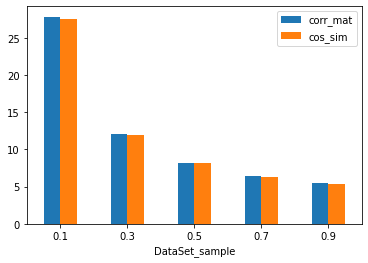

In [190]:
covrage_comparing_df.set_index("DataSet_sample").plot.bar(rot=0)

- the coverage decrease with bigger data set and that is uderstandable bec. we incerese the number of Adopters while we keep the Cat numbers (Cat_df_online) contant 
- there is a little advantage for the correlation_matrix methoud, however this diffrence decrease with the Dataset size
- the catalogue coverage for recommender when using "correlation matrix" is 5.4% on 90% (2670 Adopter) of our Dataset while using "Cosine_similarity" gives 5.3 %  

conclusion 

- this is not the best metric for comparison Or maybe it is better to revise our coverage concept  

### Calculating pediction coverage (for correlation _matrix only )

 pediction coverage:the percentage of the items for which the system is able to generate a recommendation.
 
 
for implementation,
- so we calucted the percenatge of the Items recommended (cats) that exceeds a certain threshold number

- to deduce the threshold we thought of clastering the remendations as follows:
    - relevant recommendation = correlation above 0.85 
    - not relevant recommendation = else   
    
limitaions :    
- this threshold is abribtray for testing, however for real implemention a user A/B testing have to be performed 
- this threshold can not be gernerlized on other engines for ex.Cosine similarity 

In [250]:
df_eval_user = recommend_cat_corr(0)
df_eval_user['Relevant_recommendation'] =df_eval_user["correlation_cat"].apply(lambda x: (x > 0.85)).replace({True: 1, False: 0})
df_eval_user

,correlation_cat,cat_name,ID_original,Relevant_recommendation
184,0.902050,Brett,C-2841,1
242,0.884802,Tonya,C-2342,1
127,0.872395,Leslie,C-2669,1
418,0.867890,Guadalupe,C-2299,1
435,0.855403,Walter,C-62,1
867,0.848854,Zina,C-1497,0
837,0.848562,Celeste,C-196,0
228,0.847168,David,C-597,0
69,0.842206,April,C-2630,0
874,0.826581,Cleveland,C-1281,0


In [251]:
df_eval_user_cosine = recommend_cat_cosine(0)
df_eval_user_cosine ['Relevant_recommendation'] =df_eval_user_cosine["correlation_cat"].apply(lambda x: (x > 0.85)).replace({True: 1, False: 0})
df_eval_user_cosine 

,correlation_cat,cat_name,ID_original,Relevant_recommendation
871,0.980219,Sandra,C-1796,1
242,0.977618,Tonya,C-2342,1
127,0.974489,Leslie,C-2669,1
418,0.973856,Guadalupe,C-2299,1
435,0.972272,Walter,C-62,1
867,0.971059,Zina,C-1497,1
228,0.970920,David,C-597,1
69,0.969244,April,C-2630,1
837,0.968936,Celeste,C-196,1
577,0.965518,Sarah,C-351,1


In [252]:
pediction_coverage = df_eval_user['Relevant_recommendation'].sum()/len(df_eval_user)
print ("pediction_coverage for one user is",pediction_coverage )
#possible_relevant_items = df_eval['Relevant_recommendation'].value_counts()[0]
#df_eval['Relevant_recommendation'].sum()/len(df_eval)

pediction_coverage for one user is 0.5


In [253]:
## testing in samll loob ##        ### Can be Deleted ###

Adopter_total_Accuracy =[]
for n in [0,1,2,3,4,5]:
    df_eval_user = recommend_cat_corr(n)
    df_eval_user['Relevant_recommendation'] =df_eval_user["correlation_cat"].apply(lambda x: (x > 0.85)).replace({True: 1, False: 0})
    pediction_coverage = df_eval_user['Relevant_recommendation'].sum()/len(df_eval_user)
    Adopter_total_Accuracy .append(pediction_coverage)

print(Adopter_total_Accuracy)
average_Accuracy = sum(Adopter_total_Accuracy )/len (Adopter_total_Accuracy ) 
average_Accuracy 

[0.5, 1.0, 0.0, 1.0, 1.0, 0.0]


0.5833333333333334

In [255]:
## this def makes a sample Dataframe from the Dataset then calcultes the average pediction coverage  ##

def average_prediction_coverage  (random_state,frac):
    df_adopters_Test=df_adopters.sample(frac=frac, replace=True, random_state=random_state).drop_duplicates()
    Sample_num = len(df_adopters_Test.index)
    Adopter_total_Accuracy =[]
    for n in df_adopters_Test.index :
        df_eval_user = recommend_cat_corr(n)
        df_eval_user['Relevant_recommendation'] =df_eval_user["correlation_cat"].apply(lambda x: (x > 0.85)).replace({True: 1, False: 0})
        pediction_coverage = df_eval_user['Relevant_recommendation'].sum()/len(df_eval_user)
        Adopter_total_Accuracy .append(pediction_coverage)
    Adopter_total_Accuracy
    df_pres_count = pd.DataFrame(data =Adopter_total_Accuracy, columns= ["Adopter_Accuracy"]).value_counts(normalize=True)
    #count_distribution=df_pres_count.plot(kind='bar',title=' pediction count distribution')
    average_pediction_coverage = sum(Adopter_total_Accuracy )/len (Adopter_total_Accuracy )
    

    print ("average_pediction_coverage is",average_pediction_coverage)
    return df_pres_count

In [238]:
pedict_cover_df = average_prediction_coverage (100,1)
pedict_cover_df 

average_pediction_coverage is 0.8967917346383903


In [242]:
pedict_cover_df 

Adopter_Accuracy
1.0                 0.858075
0.0                 0.051115
0.2                 0.015769
0.3                 0.014682
0.1                 0.012507
0.7                 0.010332
0.5                 0.009788
0.8                 0.009788
0.4                 0.008157
0.6                 0.007069
0.9                 0.002719
dtype: float64

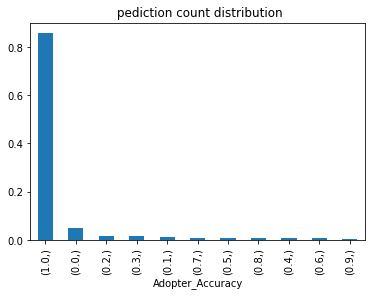

In [243]:
 count_distribution=pedict_cover_df.plot(kind='bar',title=' pediction count distribution')   

after anaylzing the predictions of all the users.
- we have 85 % of the users get all their 10 recommedations above our thereshold (0.85 correlation value) , while only 5% get none of their 10 recommendations above the thereshold